In [40]:
#Initial Library Call
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
"""
Sentiment Class:
    0 - Negative
    1 - Somewhat Negative
    2 - Neutral
    3 - Somewhat Positive
    4 - Positive
    \t - Tab
"""
train_df = pd.read_csv("../Data/train.tsv",sep = "\t")
test_df = pd.read_csv("../Data/test.tsv",sep = "\t")

In [42]:
#print (train_df.shape)
#print (train_df.head())
class_distribution = train_df["Sentiment"].value_counts()
print (class_distribution)

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


Text(0, 0.5, 'Frequency')

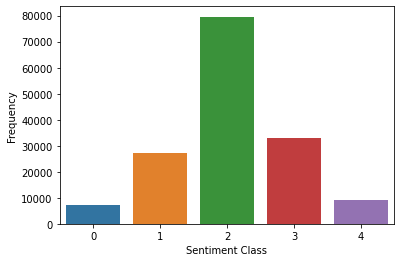

In [22]:
sns.barplot(np.array(class_distribution.index),np.array(class_distribution.values))
plt.xlabel("Sentiment Class")
plt.ylabel("Frequency")

In [43]:
u_num_reviews = len(train_df["SentenceId"].unique())#to check no duplication
avg_word_per_sentence  = train_df.groupby("SentenceId")["Phrase"].count().mean()

print (u_num_reviews)
print (avg_word_per_sentence)

# print (train_df["Phrase"])

8529
18.297572986282095


In [44]:
#Word Cloud Visualization
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(list(STOPWORDS)+ list(stopwords.words('english')))


def wcloud(phrase):
    wordcloud = WordCloud(background_color='black',stopwords=stopwords,random_state=1).generate(str(phrase))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    
    plt.imshow(wordcloud)
    plt.show()
    
    return None
    

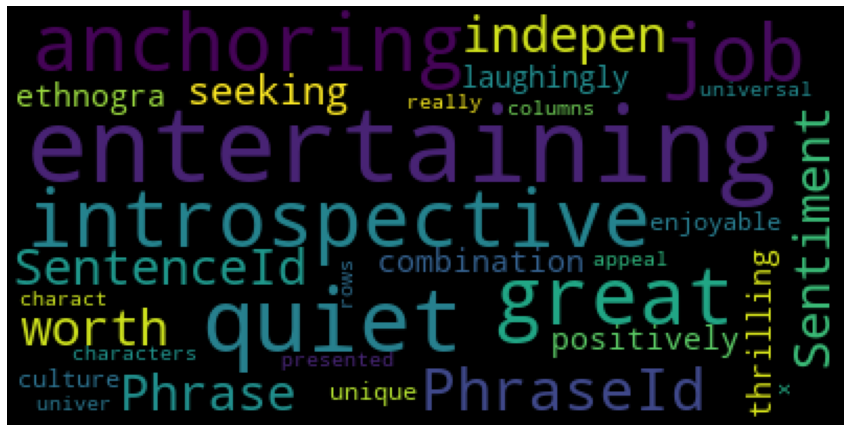

In [45]:
wcloud(train_df[train_df["Sentiment"]==4])

In [46]:
train_df["Phrase"] = train_df["Phrase"].str.lower()  #Normalizing the words- Everything to lower case

In [47]:

import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer#Split a sentence in words
w_tokenizer = TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemma(text):
    return " ".join([lemmatizer.lemmatize(w) for w  in w_tokenizer.tokenize(text)])#input is sentance

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MAHESHWARI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
train_df["Processed_Phrase"] = train_df.Phrase.apply(lemma)
test_df["Processed_Phrase"] = test_df.Phrase.apply(lemma)

In [30]:
print (train_df.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  a series of escapades demonstrating the adage ...   
1         2           1  a series of escapades demonstrating the adage ...   
2         3           1                                           a series   
3         4           1                                                  a   
4         5           1                                             series   

   Sentiment                                   Processed_Phrase  
0          1  a series of escapade demonstrating the adage t...  
1          2  a series of escapade demonstrating the adage t...  
2          2                                           a series  
3          2                                                  a  
4          2                                             series  


In [49]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer 
 

tokenizer = TweetTokenizer()


vectorizer = TfidfVectorizer(ngram_range=(1, 3))
full_text = list(train_df['Processed_Phrase'].values) + list(test_df['Processed_Phrase'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train_df['Processed_Phrase']) #TFIDF vector for train data set

Y = train_df["Sentiment"] #Labels

print (Y)

0         1
1         2
2         2
3         2
4         2
         ..
156055    2
156056    1
156057    3
156058    2
156059    2
Name: Sentiment, Length: 156060, dtype: int64


In [ ]:
# Deep Learning Based Model

In [39]:
from keras.utils import to_categorical
# target = train_df.Sentiment.values
Y = to_categorical(Y)
Y

ModuleNotFoundError: No module named 'keras'

In [36]:
max_features = 13000
max_words = 50
batch_size = 128
epochs = 7
num_classes = 5

In [36]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(train_df["Processed_Phrase"],Y,test_size = 0.20)

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [32]:
import pickle
with open('vectorizer_new_v2', 'wb') as output:
    pickle.dump(tokenizer, output)

In [15]:
x_train =pad_sequences(x_train, maxlen=max_words)
x_test = pad_sequences(x_test, maxlen=max_words)

In [21]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

print (x_train.shape)
print (y_train.shape)
smote = SMOTE(random_state=0)
train_df_smote, y_smote = smote.fit_resample(x_train, y_train)

x_train = train_df_smote
y_train = y_smote

y_train_org = np.argmax(y_train, axis=-1)
# y_dummy_df = pd.DataFrame({"Balanced_Labels":y_train_org})
# print (y_dummy_df["Balanced_Labels"].value_counts())

(318425, 50)
(318425, 5)


In [37]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [38]:
#Logistic Regression
lin_reg = LogisticRegression()
one_vs_all_regression = OneVsRestClassifier(lin_reg)
one_vs_all_regression.fit(x_train,y_train)
print(classification_report( one_vs_all_regression.predict(x_test) , y_test))
print(accuracy_score( one_vs_all_regression.predict(x_test) , y_test ))

C:\Users\MAHESHWARI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'the extremely competent hitman film'

In [25]:
# Decision Tree - Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=5,n_estimators=5,criterion="entropy")
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [26]:
print(classification_report( rf.predict(x_test) , y_test))
print(accuracy_score( rf.predict(x_test) , y_test ))

              precision    recall  f1-score   support

           0       0.26      0.25      0.25      1475
           1       0.28      0.37      0.32      4211
           2       0.41      0.68      0.51      9540
           3       0.29      0.39      0.33      4899
           4       0.27      0.26      0.26      1876

   micro avg       0.35      0.49      0.41     22001
   macro avg       0.30      0.39      0.34     22001
weighted avg       0.34      0.49      0.40     22001
 samples avg       0.35      0.35      0.35     22001

0.3469178521081635


C:\Users\Byom Kesh Jha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.4,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.001),metrics=['categorical_accuracy'])
model_GRU.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          31680     
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,341,157
Trainable params: 1,341,157
Non-trainable params: 0
_________________________________________________________________


In [29]:
history1=model_GRU.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=epochs, batch_size=batch_size, verbose=1)


Train on 318425 samples, validate on 31212 samples
Epoch 1/2
318425/318425 [==============================] - 942s 3ms/step - loss: 1.3910 - categorical_accuracy: 0.4080 - val_loss: 1.1015 - val_categorical_accuracy: 0.5902
Epoch 2/2
318425/318425 [==============================] - 1180s 4ms/step - loss: 1.2331 - categorical_accuracy: 0.4850 - val_loss: 1.0648 - val_categorical_accuracy: 0.6020


In [30]:
from sklearn.metrics import classification_report
y_test_pred=model_GRU.predict_classes(x_test, verbose=1)

y_test_num = np.argmax(y_test, axis=-1)

print (y_test_pred)
print (y_test_num)

print(classification_report( y_test_pred, y_test_num))


31212/31212 [==============================] - 71s 2ms/step
[3 1 4 ... 4 2 1]
[2 2 3 ... 2 1 2]
              precision    recall  f1-score   support

           0       0.44      0.35      0.39      1771
           1       0.50      0.49      0.50      5585
           2       0.71      0.75      0.73     15252
           3       0.45      0.54      0.49      5571
           4       0.60      0.36      0.45      3033

    accuracy                           0.60     31212
   macro avg       0.54      0.50      0.51     31212
weighted avg       0.60      0.60      0.60     31212



===============================================================LSTM==========================================================

In [37]:
model3_LSTM=Sequential()
model3_LSTM.add(Embedding(max_features,100,mask_zero=True))
model3_LSTM.add(LSTM(64,dropout=0.4,return_sequences=True))
model3_LSTM.add(LSTM(32,dropout=0.5,return_sequences=False))
model3_LSTM.add(Dense(num_classes,activation='sigmoid'))
model3_LSTM.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.001),metrics=['categorical_accuracy'])
model3_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 1,354,821
Trainable params: 1,354,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3=model3_LSTM.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 318425 samples, validate on 31212 samples
Epoch 1/7
318425/318425 [==============================] - 871s 3ms/step - loss: 0.4642 - categorical_accuracy: 0.3634 - val_loss: 0.3748 - val_categorical_accuracy: 0.5858
Epoch 2/7
318425/318425 [==============================] - 1262s 4ms/step - loss: 0.4128 - categorical_accuracy: 0.4660 - val_loss: 0.3684 - val_categorical_accuracy: 0.5846
Epoch 3/7
310144/318425 [============================>.] - ETA: 17s - loss: 0.3916 - categorical_accuracy: 0.4988

In [ ]:
from sklearn.metrics import classification_report
y_test_pred=model3_LSTM.predict_classes(x_test, verbose=1)

y_test_num = np.argmax(y_test, axis=-1)

dum_df = pd.DataFrame({"Y_Test":y_test_num})
print (dum_df["Y_Test"].value_counts())

# print (y_test_pred)
# print (y_test_num)

print(classification_report( y_test_pred, y_test_num))



In [ ]:
import pickle
with open('lstm_model', 'wb') as output:
    pickle.dump(model3_LSTM, output)